In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

dataset = datasets.CIFAR10(root="/kaggle/working",
                           train=True,
                           download=True,
                           transform=transform)

loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=128,
                                     shuffle=True,
                                     num_workers=2)

100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


In [4]:
def rgb_to_gray(x):
    r,g,b = x[:,0:1], x[:,1:2], x[:,2:3]
    gray = 0.299*r + 0.587*g + 0.114*b
    return gray.repeat(1,3,1,1)   # keep 3 channels

In [5]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3,64,4,2,1),  # 32→16
            nn.ReLU(),

            nn.Conv2d(64,128,4,2,1), # 16→8
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128,256,4,2,1), # 8→4
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256,128,4,2,1), # 4→8
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128,64,4,2,1), # 8→16
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64,3,4,2,1), # 16→32
            nn.Tanh()
        )

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = EncoderDecoder().to(device)
model

EncoderDecoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): T

In [6]:
criterion_L1 = nn.L1Loss()
criterion_MSE = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0002)

In [7]:
epochs = 8

for epoch in range(epochs):
    total_loss = 0

    for img,_ in loader:
        img = img.to(device)
        target = rgb_to_gray(img).to(device)

        optimizer.zero_grad()

        output = model(img)

        loss_L1 = criterion_L1(output, target)
        loss_MSE = criterion_MSE(output, target)

        loss = loss_L1 + loss_MSE
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} Loss: {total_loss/len(loader):.4f}")

Epoch 1/8 Loss: 0.1737
Epoch 2/8 Loss: 0.0834
Epoch 3/8 Loss: 0.0697
Epoch 4/8 Loss: 0.0607
Epoch 5/8 Loss: 0.0567
Epoch 6/8 Loss: 0.0535
Epoch 7/8 Loss: 0.0501
Epoch 8/8 Loss: 0.0471


In [8]:
def denorm(x):
    return (x + 1) / 2

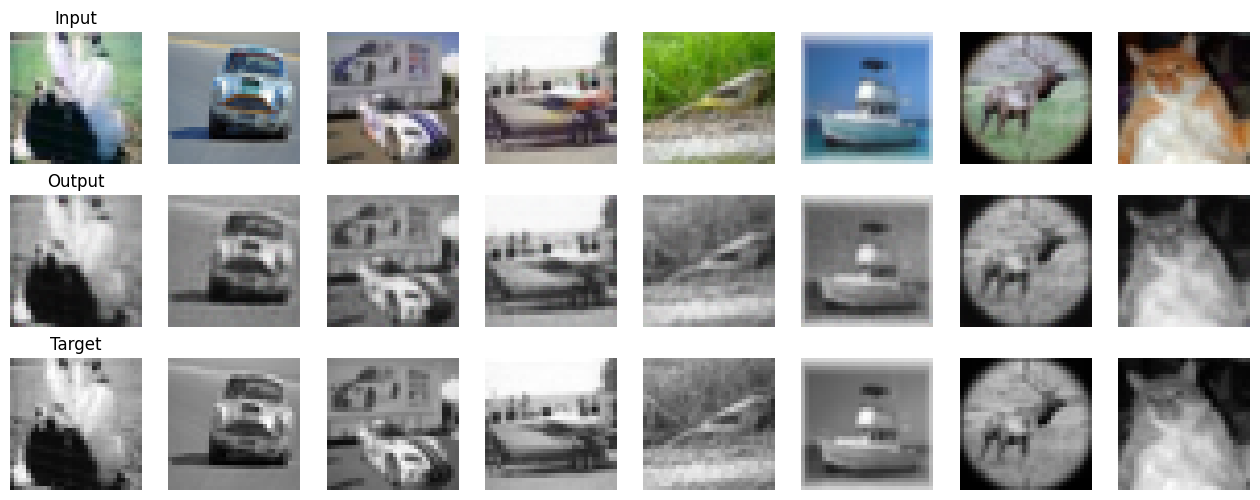

In [9]:
model.eval()

imgs,_ = next(iter(loader))
imgs = imgs[:8].to(device)

with torch.no_grad():
    outputs = model(imgs)

targets = rgb_to_gray(imgs)

imgs = denorm(imgs).cpu()
outputs = denorm(outputs).cpu()
targets = denorm(targets).cpu()

fig,ax = plt.subplots(3,8,figsize=(16,6))

for i in range(8):
    ax[0,i].imshow(np.transpose(imgs[i],(1,2,0)))
    ax[0,i].axis("off")

    ax[1,i].imshow(np.transpose(outputs[i],(1,2,0)))
    ax[1,i].axis("off")

    ax[2,i].imshow(np.transpose(targets[i],(1,2,0)))
    ax[2,i].axis("off")

ax[0,0].set_title("Input")
ax[1,0].set_title("Output")
ax[2,0].set_title("Target")

plt.show()

In [10]:
model.eval()
total_L1,total_MSE,count = 0,0,0

with torch.no_grad():
    for img,_ in loader:
        img = img.to(device)
        target = rgb_to_gray(img)

        output = model(img)

        total_L1 += criterion_L1(output,target).item()
        total_MSE += criterion_MSE(output,target).item()
        count += 1

print("Average L1 Loss:", total_L1/count)
print("Average MSE Loss:", total_MSE/count)

Average L1 Loss: 0.034967856791318225
Average MSE Loss: 0.002348968748460569


In [11]:
import torch
import torchvision.transforms as T
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model = model.to(device).eval()

(np.float64(-0.5), np.float64(3839.5), np.float64(2159.5), np.float64(-0.5))

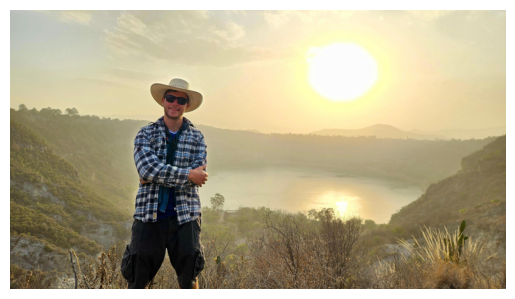

In [16]:
img = Image.open("/content/774b8330-f15f-11f0-8c02-e5e7c184d682.jpg").convert("RGB")
plt.imshow(img)
plt.axis("off")

In [17]:
transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],
                std=[0.229,0.224,0.225])
])

input_tensor = transform(img).unsqueeze(0).to(device)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

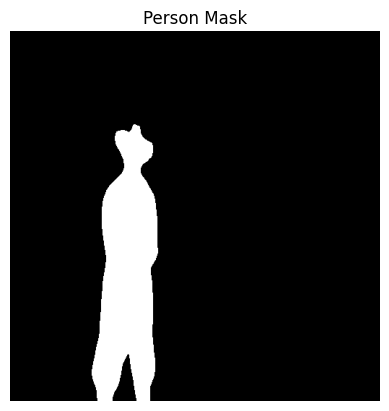

In [18]:
with torch.no_grad():
    output = model(input_tensor)["out"][0]

mask = output.argmax(0).cpu().numpy()

# Class 15 = person in COCO dataset
person_mask = (mask == 15).astype(np.uint8)

plt.imshow(person_mask, cmap="gray")
plt.title("Person Mask")
plt.axis("off")

In [19]:
person_mask = Image.fromarray(person_mask*255).resize(img.size)
person_mask = np.array(person_mask)/255
person_mask = np.expand_dims(person_mask,axis=2)

(np.float64(-0.5), np.float64(3839.5), np.float64(2159.5), np.float64(-0.5))

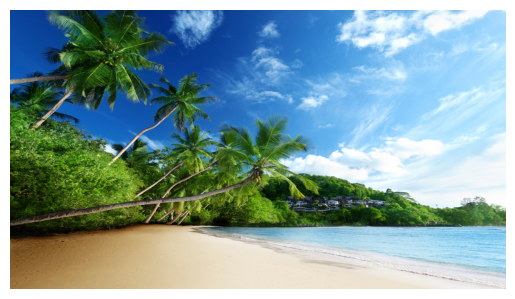

In [21]:
bg = Image.open("/content/Tropical_Beach_Background.jpg").convert("RGB")
bg = bg.resize(img.size)

plt.imshow(bg)
plt.axis("off")

(np.float64(-0.5), np.float64(3839.5), np.float64(2159.5), np.float64(-0.5))

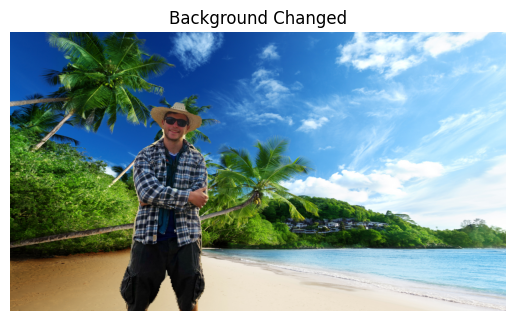

In [22]:
img_np = np.array(img)/255
bg_np = np.array(bg)/255

result = img_np*person_mask + bg_np*(1-person_mask)

plt.imshow(result)
plt.title("Background Changed")
plt.axis("off")